---
title: "How to Save & Load FastAI Model"
execute: 
  enabled: false
  freeze: true
date: "7/19/2024"
categories: [fastai, export, load]
---


> Save model using `learn.export(checkpoint_path)`. Load using `learn = load_learner(checkpoint_path)`

I had a hard time figuring out how to save and load trained fastai model. So, this is a guide to remind myself of what I've tried (and failed), and what works.

In [3]:
import pickle
import gc
import os
import glob
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import *


In [3]:
import fastai
fastai.__version__

'2.7.15'

In [4]:
def unpickle(fp):
    print('loading', fp)
    with open(fp, 'rb') as f:
        x = pd.read_pickle(f)
        # x = pickle.load(f, encoding='ASCII')
    return x


def unpickle_multiple_pd(path:Union[str,list], drop_dup_on_cols:Union[None, list]) -> pd.DataFrame:
    """unpickle multiple pandas dataframes
    input & output = pandas df

    if `drop_dup_on_cols` is not None, will drop duplicate on `drop_dup_on_cols` cols.
    """
    import gc
    import glob
    
    print('path', type(path), path)
    if isinstance(path, list):
        filenames = path
    else:

        filenames = list(glob.glob(path))
        
    print('loading', filenames)
    if len(filenames) > 1:
        
        loaded_file = []

        for i,f in enumerate(filenames):
            if f != '':
                try:
                    loaded_file.append(unpickle(f))
                    print('i', i)
                    gc.collect()
                except:
                    print('loading error')
                    continue
        gc.collect()
        df = pd.concat(loaded_file)
        if drop_dup_on_cols is not None:
            df = df.drop_duplicates(subset=drop_dup_on_cols)
        return df.reset_index(drop=True)
    return unpickle(filenames[0])



def save_pickle(fp:str, x) -> None:
    with open(fp, 'wb') as f:
        pickle.dump(x, f)
    print('saved pickle', fp)

In [3]:
fp = '/kaggle/input/ordergen-transformers-prepostprocesd-17072024/Archive2/20210104_20231031_trainxyz_testxyz_ori.pkl'
Xtrain, ytrain, train_annos, Xtest, ytest, test_annos = unpickle(fp)


loading /kaggle/input/ordergen-transformers-prepostprocesd-17072024/Archive2/20210104_20231031_trainxyz_testxyz_ori.pkl


In [8]:
print(Xtrain.shape)
Xtrain

(839200, 744)


array([[ 0.8008967 ,  0.8019981 ,  0.70472926, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.37820956,  0.37688217,  0.37682053, ...,  0.        ,
         0.        ,  0.        ],
       [-0.30258572, -0.3024994 , -0.3730603 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.        , -1.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -1.        , -1.        , ...,  0.        ,
         0.        ,  0.        ],
       [-1.        , -1.        , -1.        , ...,  0.        ,
         0.        ,  0.6666667 ]], dtype=float32)

In [9]:
print(ytrain.shape)
ytrain

(839200, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

In [4]:
def pass_index(idx):
    return idx

def get_x(i):
    return image[i]

def get_y(i):
    return label[i]


In [5]:
SLICE = 1000 # for demonstration, we will work on small sample slice only

image = Xtrain[:SLICE]
label = ytrain[:SLICE,0] # select the first axis (col) because my labels are in 2 dimensional ie (total rows, 1)

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=pass_index,
    get_x=get_x,
    get_y=get_y)

# pass in a list of index
num_images = image.shape[0]
dls = dblock.dataloaders(list(range(num_images)))


Note: We won't be able to save the model if we have nested functions. Like below. Notice we have `pass_index`, `get_x`, `get_y` functions inside the `make_dataloaders_from_numpy_data`. The workaround is to move it out of the function.

```

def make_dataloaders_from_numpy_data(image, label):
    def pass_index(idx):
        return idx

    def get_x(i):
        return image[i]

    def get_y(i):
        return label[i]

    dblock = DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_items=pass_index,
        get_x=get_x,
        get_y=get_y)

    # pass in a list of index
    num_images = image.shape[0]
    dls = dblock.dataloaders(list(range(num_images)))

    return dls

dls = make_dataloaders_from_numpy_data(Xtrain, ytrain[:,0])

```

# Train model

In [6]:
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 133MB/s] 


In [15]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.690889,0.820386,0.810000,00:48


epoch,train_loss,valid_loss,accuracy,time
0,0.534998,0.656172,0.805000,01:04
1,0.519913,0.644092,0.660000,01:05
2,0.501660,0.590537,0.755000,01:04
3,0.481192,0.602440,0.800000,01:04
4,0.448506,0.559592,0.775000,01:05
5,0.395029,0.629317,0.735000,01:05
6,0.354913,0.627367,0.800000,01:04
7,0.302945,0.688665,0.780000,01:04
8,0.265921,0.668892,0.790000,01:05
9,0.231195,0.661298,0.785000,01:05


For fun, let's plot the model's loss, and confusion matrix.

<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

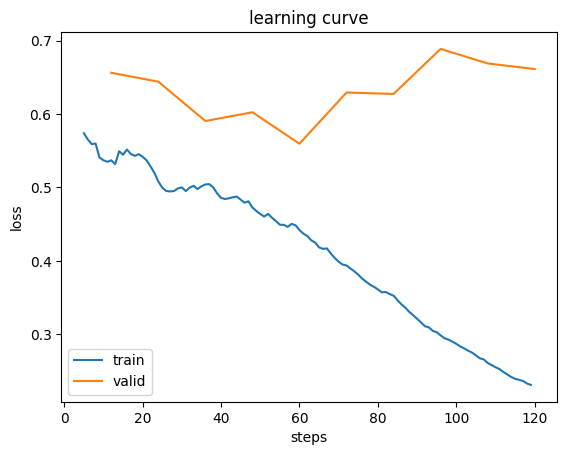

In [16]:
learn.recorder.plot_loss()

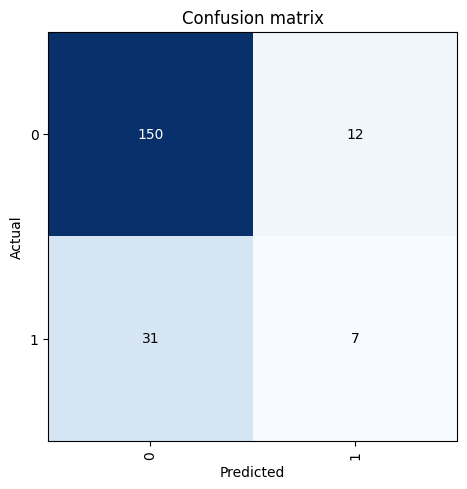

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()


# Save trained model

I saved my trained model in 3 different file extensions (1 of them is actually saved without any specified file extension).

In [ ]:
checkpoint_path = '/kaggle/working/my_fastai_model_export'
learn.export(checkpoint_path)

In [ ]:
checkpoint_path = '/kaggle/working/my_fastai_model_pth_export.pth'
learn.export(checkpoint_path)

In [21]:

checkpoint_path = '/kaggle/working/my_fastai_pkl_export.pkl'
learn.export(checkpoint_path)


# Load trained model & get batch predictions

To load trained model, I restart the kernel so we can test that this actually works. I did not rerun any code cells above, just the importing libraries cell. 

First of, we need to reinitialize all our dataset preprocessing things. But instead of working with the same training data, we will load out of sample test set.

In [5]:

fp = '/kaggle/input/ordergen-transformers-prepostprocesd-17072024/Archive2/20240429_20240503_testxyz_ori.pkl'
test_features, test_targets, annotations = unpickle(fp)


loading /kaggle/input/ordergen-transformers-prepostprocesd-17072024/Archive2/20240429_20240503_testxyz_ori.pkl


In [6]:
print(test_features.shape)
test_features

(26856, 744)


array([[ 0.6689392 ,  0.6722139 ,  0.66988313, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.56092703,  0.5576653 ,  0.5589551 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.1795841 , -0.18068182, -0.17959571, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.25185028,  0.25209376,  0.25152162, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.8822221 ,  0.88193876,  0.8785461 , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5615684 , -0.6948581 , -0.68838125, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [7]:
print(test_targets.shape)
test_targets

(26856, 1)


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)

We need to re-define the same functions and DataBlock and dataloaders we used to trained the model.

In [8]:
def pass_index(idx):
    return idx

def get_x(i):
    return image[i]

def get_y(i):
    return label[i]


But this time, using the new test set.

In [9]:
SLICE = 1000 # for demonstration, we will work on small sample slice only
image = test_features[:SLICE]
label = test_targets[:SLICE,0] # select the first axis because my labels are in 2 dimensional ie (total rows, 1)

In [10]:


dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=pass_index,
    get_x=get_x,
    get_y=get_y)

# pass in a list of index
num_images = image.shape[0]
dls = dblock.dataloaders(list(range(num_images)))


Let's test loading all our saved model one by one.

In [11]:

checkpoint_path1 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_export'


learn1 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn1 = load_learner(checkpoint_path1)

test_dl1 = learn1.dls.test_dl(test_features[:SLICE])

# get batch prediction
ypreds1, _ = learn1.get_preds(dl=test_dl1)
ypreds1

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 61.4MB/s]


tensor([[9.5914e-01, 4.0856e-02],
        [8.6308e-01, 1.3692e-01],
        [4.6716e-01, 5.3284e-01],
        ...,
        [9.9386e-01, 6.1434e-03],
        [9.2105e-01, 7.8951e-02],
        [9.9948e-01, 5.2483e-04]])

In [12]:

checkpoint_path2 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_pth_export.pth'


learn2 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn2 = load_learner(checkpoint_path2)

test_dl2 = learn2.dls.test_dl(test_features[:SLICE])

# get batch prediction
ypreds2, _ = learn2.get_preds(dl=test_dl2)
ypreds2

tensor([[9.5914e-01, 4.0856e-02],
        [8.6308e-01, 1.3692e-01],
        [4.6716e-01, 5.3284e-01],
        ...,
        [9.9386e-01, 6.1434e-03],
        [9.2105e-01, 7.8951e-02],
        [9.9948e-01, 5.2483e-04]])

In [15]:

checkpoint_path3 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_pkl_export.pkl'


learn3 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn3 = load_learner(checkpoint_path3)

test_dl3 = learn3.dls.test_dl(test_features[:SLICE])

# get batch prediction
ypreds3, _ = learn3.get_preds(dl=test_dl3)
ypreds3

tensor([[9.5914e-01, 4.0856e-02],
        [8.6308e-01, 1.3692e-01],
        [4.6716e-01, 5.3284e-01],
        ...,
        [9.9386e-01, 6.1434e-03],
        [9.2105e-01, 7.8951e-02],
        [9.9948e-01, 5.2483e-04]])

# (...What doesn't work)
Using `learn.load(checkpoint_path)` does not work. For some reason I get FileNotFoundError but they clearly exist...

In [16]:

checkpoint_path01 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_export'
learn01 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn01.load(checkpoint_path01)  # this does not work

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_export.pth'

In [17]:

checkpoint_path02 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_pth_export.pth'
learn02 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn02.load(checkpoint_path02)  # this does not work

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_model_pth_export.pth.pth'

In [26]:

checkpoint_path03 = '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_pkl_export'
learn03 = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn03.load(checkpoint_path03)  # this does not work

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/dummy_fastai_model/other/test2/1/my_fastai_pkl_export.pth'

# Checking our ypreds

<Axes: >

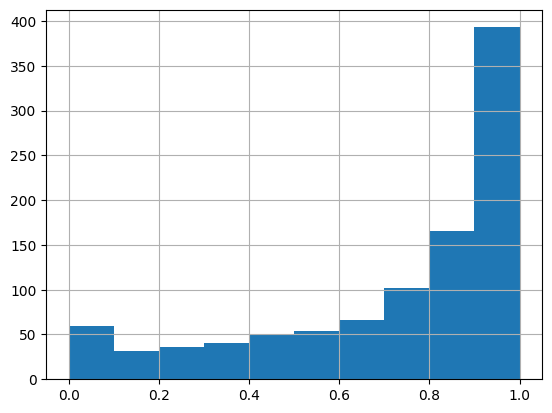

In [19]:
# probabilities for class0
pd.DataFrame(ypreds1)[0].hist()

<Axes: >

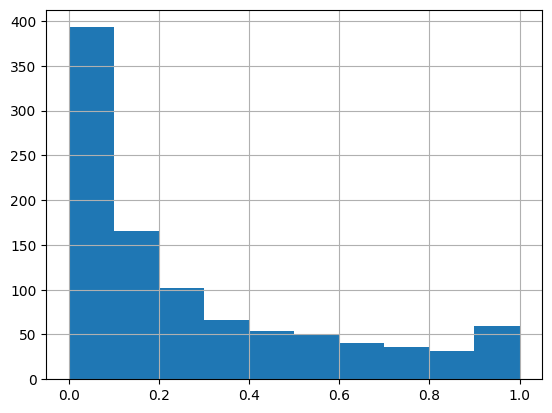

In [21]:
# probabilities for class 1
pd.DataFrame(ypreds1)[1].hist()

All is well, but for some reason, I could not plot a confusion matrix.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn3)
interp.plot_confusion_matrix()

"""
Traceback:
{
	"name": "ValueError",
	"message": "not enough values to unpack (expected 3, got 2)",
	"stack": "---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[25], line 2
      1 interp = ClassificationInterpretation.from_learner(learn3)
----> 2 interp.plot_confusion_matrix()

File /opt/conda/lib/python3.10/site-packages/fastai/interpret.py:130, in ClassificationInterpretation.plot_confusion_matrix(self, normalize, title, cmap, norm_dec, plot_txt, **kwargs)
    128 \"Plot the confusion matrix, with `title` and using `cmap`.\"
    129 # This function is mainly copied from the sklearn docs
--> 130 cm = self.confusion_matrix()
    131 if normalize: cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    132 fig = plt.figure(**kwargs)

File /opt/conda/lib/python3.10/site-packages/fastai/interpret.py:114, in ClassificationInterpretation.confusion_matrix(self)
    112 \"Confusion matrix as an `np.ndarray`.\"
    113 x = torch.arange(0, len(self.vocab))
--> 114 _,targs,decoded = self.learn.get_preds(dl=self.dl, with_decoded=True, with_preds=True, 
    115                                        with_targs=True, act=self.act)
    116 d,t = flatten_check(decoded, targs)
    117 cm = ((d==x[:,None]) & (t==x[:,None,None])).long().sum(2)

ValueError: not enough values to unpack (expected 3, got 2)"
}
"""

# Conclusion
This is all still a bit of a mystery to me. I just started learning to use the library, but as of now it feels like the API is not very stable. I had to experiment a lot of times to get the trained model working. And it is puzzling that I did not run into any error in another notebook. Here is what I did in another notebook that I could not successfully replicate here.
```
# load data and train model..

# save model
checkpoint_path = 'fastai_timeseries.pkl'
learn.export(checkpoint_path)

# I restart kernel here before continuing below.

# redefine everything
image = test_features
label = test_targets[:,0]

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=pass_index,
    get_x=get_x,
    get_y=get_y)

num_images = image.shape[0]
dls = dblock.dataloaders(list(range(num_images)))

# init learn
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)

# load model
checkpoint_path = '/kaggle/input/ordergen_timeseries_fastai/other/default/1/fastai_timeseries'
learn.load(checkpoint_path)        #### <-------- diff is here
```



So, in short:
1. We save model by `learn.export(checkpoint_path)`

2. The file extension for `checkpoint_path` does not matter. When I omit the file extension entirely, we can still load and get predictions. Here is what I tried as `checkpoint_path`: ['model', 'model.pth', 'model.pkl'].


3. We need to redefine all functions we used to trained the model (ie `get_x`, `get_y`, ...).


4. We load model by:

```
checkpoint_path = any one of ['model', 'model.pth', 'model.pkl']

# load model
learn = vision_learner(dls, models.resnet18, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn = load_learner(checkpoint_path)

# init test dataloader
test_dl = learn.dls.test_dl(test_features)

# get batch prediction
ypreds, _ = learn.get_preds(dl=test_dl)
```